### Import & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
from pathlib import Path
project_dir = Path().resolve().parent
sys.path.append(str(project_dir))

In [10]:
print(f"Project dir: {project_dir}")

Project dir: D:\PersonalFiles\Development\Git Projects\data-analytics-portfolio\trading-signal


In [16]:
from backtest.strategies import AtrDynamicStopStrategy, AtrLongOnlyStrategy   
from backtest.backtest import run_backtest, extract_trades_df, get_equity_series, plot_pnl_curve, print_bt_evals  

### Configs

In [150]:
# === 全局配置：按需修改 ===
DB_PATH   = '../data/crypto_data.db'     # SQLite 路径
SYMBOL    = "ETHUSDT"            # 回测的交易对
START_STR = "2025-09-03 00:00:00"
END_STR   = "2025-09-13 23:59:59"
TIMEZONE  = None                 # 若你的 signals 表时间戳为“无时区的 UTC”，就保持 None

In [156]:
# 策略配置
STRATEGY_CLASS = AtrDynamicStopStrategy      # 或者：AtrLongOnlyStrategy

# 策略参数（与你的策略一致，可随时改）
STRATEGY_PARAMS = dict(
    atr_period=8,
    atr_tp_factor=1,
    atr_sl_factor=1.5,
    # signal_column 参数在策略里目前没直接用到，
    # 我们在数据层将“被回测的信号列”复制到 feed 需要的 'final_signal'
)

# 需要对比的信号列（来自 signals 表）
SIGNAL_COLS = ["raw_signal", "filtered_signal", "final_signal"]  

### Read signals table

In [26]:
# 从 SQLite 读取并清洗数据（假设 signals 表里就有 OHLCV & 多个信号列）
def load_signals_frame(db_path, symbol, start_str=None, end_str=None, tz=None):
    con = sqlite3.connect(db_path)
    q = f"""
    SELECT *
    FROM signals
    WHERE symbol = ?
      AND datetime >= COALESCE(?, datetime)
      AND datetime <= COALESCE(?, datetime)
    ORDER BY datetime ASC
    """
    df = pd.read_sql_query(q, con, params=[symbol, start_str, end_str])
    con.close()

    # 规范列名
    # 期望列：datetime, open, high, low, close, volume, raw_signal, filtered_signal, final_signal(等)
    # 时间索引
    dt = pd.to_datetime(df["datetime"])
    if tz is not None:
        dt = dt.dt.tz_localize(tz)
    df.index = dt
    df = df.sort_index()

    # 只保留需要的基础列 + 所有可能的信号列（其余按需保留）
    base_cols = ["open", "high", "low", "close", "volume"]
    keep_cols = base_cols + [c for c in df.columns if c.endswith("signal")]
    keep_cols = [c for c in keep_cols if c in df.columns]
    df = df[keep_cols].copy()

    # 确保基础列为 float
    for c in base_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # 丢弃缺失
    df.dropna(subset=base_cols, inplace=True)
    return df

In [153]:
signals_df_all = load_signals_frame(DB_PATH, SYMBOL, START_STR, END_STR, tz=TIMEZONE)
signals_df_all.head()

,open,high,low,close,volume,raw_signal,filtered_signal,final_signal
datetime,,,,,,,,
2025-09-03 00:00:00,4324.58,4330.95,4310.64,4325.06,56082.112,0,0,0
2025-09-03 00:30:00,4325.06,4328.40,4302.00,4308.03,57073.012,0,0,0
2025-09-03 01:00:00,4308.02,4311.10,4283.48,4284.98,80232.738,0,0,0
2025-09-03 01:30:00,4284.99,4324.17,4281.00,4323.41,61797.376,-1,0,0
2025-09-03 02:00:00,4323.40,4354.00,4310.21,4351.50,148164.235,1,1,1


### Backtest

In [17]:
# 核心回测函数：循环不同信号列
def run_backtest_for_signalcol(df_all, 
                               signal_col, 
                               strategy_class, 
                               strategy_params,
                               initial_cash=100000, 
                               commission=0.0005):
    if signal_col not in df_all.columns:
        raise ValueError(f"列 {signal_col} 不在 DataFrame 中！")

    df = df_all.copy()
    # 将当前信号列映射为 backtest.PandasSignalData 需要的 'final_signal'
    df["final_signal"] = df[signal_col].astype(float)

    # Backtrader 需要列名小写且是固定名：open/high/low/close/volume + final_signal
    # 你的 PandasSignalData 已经把 lines.signal 映射到 'final_signal' 列。:contentReference[oaicite:3]{index=3}
    results = run_backtest(strategy_class=strategy_class,
                           signals_df=df,
                           strategy_params=strategy_params,
                           initial_cash=initial_cash,
                           commission=commission)
    strat = results[0]
    return strat

In [18]:
# 从 analyzers 提取核心指标，便于横向对比
def summarize_metrics(strat, initial_cash=100000):
    # Sharpe
    sharpe = strat.analyzers.sharpe.get_analysis().get('sharperatio', np.nan)

    # Drawdown
    dd = strat.analyzers.drawdown.get_analysis()
    mdd = dd.get('max', {}).get('drawdown', np.nan)

    # Returns
    ret = strat.analyzers.returns.get_analysis()
    rtot  = ret.get('rtot', np.nan)
    rnorm = ret.get('rnorm', np.nan)

    # Trade stats
    t = strat.analyzers.trades.get_analysis()
    total_trades = t.get('total', {}).get('total', 0)
    won_trades   = t.get('won', {}).get('total', 0)
    lost_trades  = t.get('lost', {}).get('total', 0)
    win_rate     = (won_trades / total_trades) if total_trades else np.nan

    # 期末权益（由逐bar收益累乘得到）
    eq = get_equity_series(strat, initial_cash=initial_cash)
    end_equity = float(eq.iloc[-1]) if not eq.empty else np.nan

    return dict(
        sharpe=sharpe,
        max_drawdown_pct=mdd,
        total_return=rtot,
        annual_return=rnorm,
        trades=total_trades,
        win_rate=win_rate,
        end_equity=end_equity,
    )


def backtest_many_signals(df_all, signal_cols, strategy_class, strategy_params,
                          initial_cash=100000, commission=0.0005):
    records = []
    strats  = {}

    for col in signal_cols:
        try:
            strat = run_backtest_for_signalcol(
                df_all=df_all, signal_col=col,
                strategy_class=strategy_class,
                strategy_params=strategy_params,
                initial_cash=initial_cash, commission=commission
            )
            metrics = summarize_metrics(strat, initial_cash=initial_cash)
            metrics['signal_col'] = col
            records.append(metrics)
            strats[col] = strat
        except Exception as e:
            records.append({'signal_col': col, 'error': str(e)})
    summary = pd.DataFrame(records).set_index('signal_col')
    return summary, strats

In [157]:
summary_df, strat_map = backtest_many_signals(
    signals_df_all, SIGNAL_COLS,
    strategy_class=STRATEGY_CLASS,
    strategy_params=STRATEGY_PARAMS,
    initial_cash=100000,
    commission=0.0005
)

summary_df

2025-09-03T05:00:00 - 开多仓 @ 4322.81 (TP=4348.67, SL=4284.03)
2025-09-03T07:00:00 - 反转做空：平多仓 @ 4299.94
2025-09-03T07:30:00 - 开空仓 @ 4307.83 (TP=4284.24, SL=4343.21)
2025-09-03T09:30:00 - 空头止损 @ 4343.21
2025-09-03T10:00:00 - 开多仓 @ 4366.91 (TP=4392.93, SL=4327.87)
2025-09-03T13:30:00 - 多头止盈 @ 4392.93
2025-09-03T14:00:00 - 开多仓 @ 4437.87 (TP=4470.72, SL=4388.59)
2025-09-03T14:30:00 - 多头止盈 @ 4470.72
2025-09-03T15:00:00 - 开空仓 @ 4454.40 (TP=4422.18, SL=4502.74)
2025-09-04T02:00:00 - 反转做多：平空仓 @ 4438.51
2025-09-04T02:30:00 - 订单失败：Margin
2025-09-04T02:30:00 - 开多仓 @ 4419.80 (TP=4442.16, SL=4386.26)
2025-09-04T04:00:00 - 多头止损 @ 4386.26
2025-09-04T05:00:00 - 开多仓 @ 4371.93 (TP=4395.56, SL=4336.49)
2025-09-04T10:00:00 - 多头止盈 @ 4395.56
2025-09-04T13:30:00 - 开空仓 @ 4375.99 (TP=4347.44, SL=4418.81)
2025-09-04T14:00:00 - 空头止盈 @ 4347.44
2025-09-04T14:30:00 - 开空仓 @ 4339.68 (TP=4308.83, SL=4385.95)
2025-09-04T15:00:00 - 空头止盈 @ 4308.83
2025-09-04T15:30:00 - 开空仓 @ 4302.61 (TP=4270.75, SL=4350.39)
2025-09-04T18:3

,sharpe,max_drawdown_pct,total_return,annual_return,trades,win_rate,end_equity
signal_col,,,,,,,
raw_signal,-0.102275,6.051518,-0.014234,-0.301408,62,0.532258,98586.716615
filtered_signal,-0.040044,4.632622,-0.006629,-0.153838,44,0.568182,99339.317340
final_signal,-0.312484,9.418125,-0.062223,-0.791543,38,0.552632,93967.321720


=== raw_signal ===


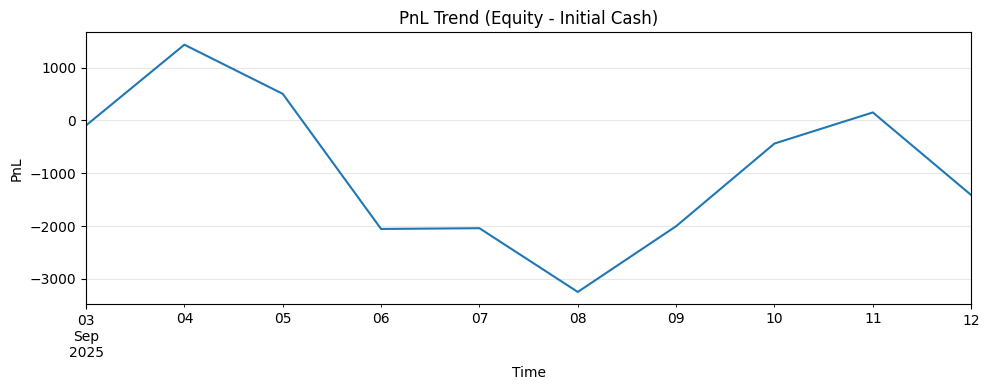

=== filtered_signal ===


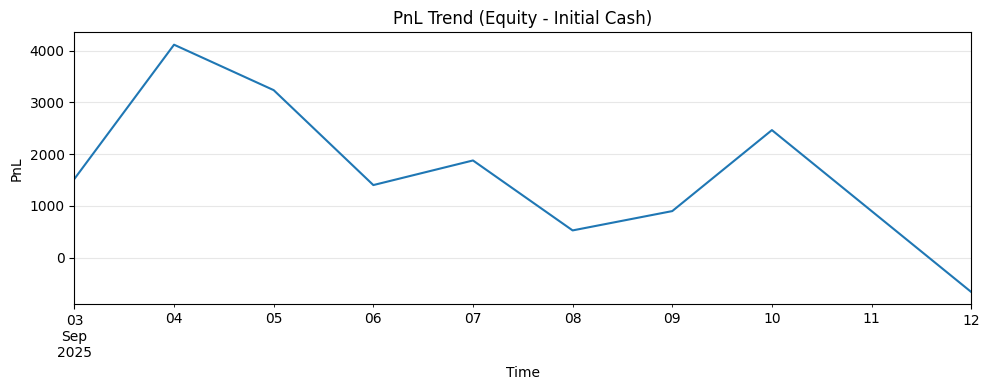

=== final_signal ===


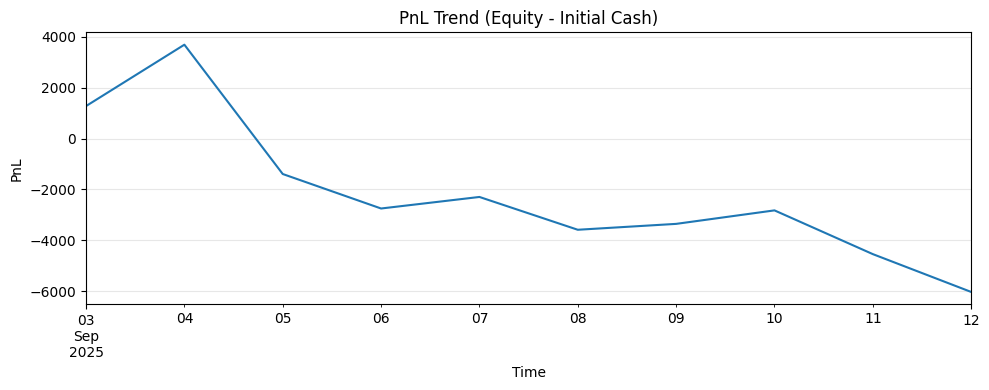

In [158]:
# Cell 5: 每个信号列一张 PnL 曲线图 + 标注平仓竖线
INITIAL_CASH = 100000

for col, strat in strat_map.items():
    print(f"=== {col} ===")
    plot_pnl_curve(strat, INITIAL_CASH, show=True)